In [48]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
pns_data = pd.read_csv('dir/national_pension.csv')
pns_data = pns_data.set_index(['Age_Group', 'Year'])
res_data = pd.read_csv('dir/recipients_national_pension.csv')
res_data = res_data.set_index(['Age_Group', 'Year'])
yn_data = pd.read_csv('dir/recipients_yn.csv')
yn_data = yn_data.set_index('Year')
per_data = pd.read_csv('dir/korea_person.csv')
# per_data = per_data.set_index('Year')
ani_data = pd.read_csv('dir/annual_income.csv')
# ani_data = ani_data.set_index('Year')

# pns_data
# res_data
# yn_date

In [49]:
# 1. 년도별 1인당 부양수
include = ['Old_Pension', 'Disability_Pension', 'Survivor_Pension']

pns_gb_data = pns_data.groupby('Year').sum()
res_gb_data = res_data.groupby('Year').sum()

res_gb_data['Recipients_Total'] = res_gb_data[include].sum(axis=1)

# res_gb_data
# res_gb_data

In [50]:
spt_data = pns_gb_data.join(res_gb_data)
spt_data = spt_data.join(yn_data)

spt_data['Spt_Per'] = (spt_data['Recipients_Total'] / (spt_data['Subscriber_Count'] * spt_data['NPay_Per'] / 100) * 100)

spt_data

,Subscriber_Count,Old_Pension,Disability_Lsp,Disability_Pension,Survivor_Pension,Return_Lsp,Death_Lsp,Recipients_Total,NPay_Per,Spt_Per
Year,,,,,,,,,,
2012,15663881,2748455,2862,75934,496073,176531,18235,3320462,77.56,27.331366
2013,16169339,2840660,2993,75041,536161,180233,18025,3451862,78.01,27.365972
2014,16554121,2947422,2651,75387,575706,147035,21219,3598515,75.49,28.795708
2015,17056789,3151349,2597,75688,617084,180705,23949,3844121,76.31,29.533731
2016,17659255,3412350,2577,75497,659124,208620,26578,4146971,77.73,30.211338
2017,17998055,3706516,2916,75486,705619,203449,22240,4487621,78.13,31.913378
2018,18612582,3778824,3072,75734,756425,159967,20354,4610983,79.58,31.130275
2019,18939569,4090497,3028,77872,808253,188851,21509,4976622,81.60,32.201374
2020,19009014,4468126,2904,78079,857698,186422,22976,5403903,78.97,35.998617


<Axes: xlabel='Year'>

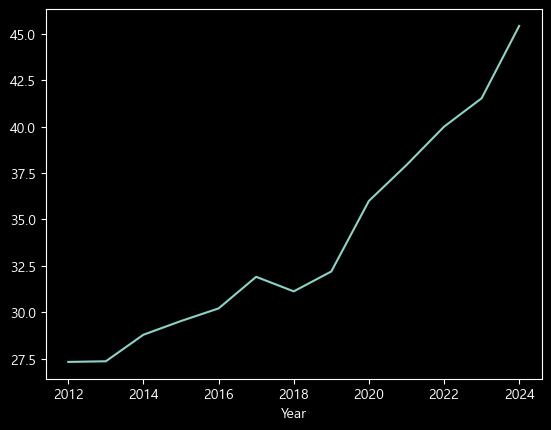

In [51]:
# 부양수 그래프
graph_data = spt_data['Spt_Per']

graph_data.plot.line()

In [52]:
# 2. 세대별 수익률
# 70년생 A
# 00년생 B
# 임금 상승도는 최저시급으로
# 100살까지 수령

def get_contribution_rate(year):
    if year < 1993: return 0.03
    elif year < 1998: return 0.06
    elif year < 2030: return 0.09
    else: return 0.12

def get_income_rate(year):
    if year <= 1998 : return 0.7
    elif year <= 2008 : return 0.6
    else : return 0.4

A = 1950
B = 2000

As = [min(year + 20, 2026) for year in range(A, A + 65) if min(year + 20, 2026) >= 1988]
Bs = [min(year + 20, 2026) for year in range(B, B + 65) if min(year + 20, 2026) >= 1988]

ani_data['Month_Salary'] = ani_data['Time_Salary'] * 40 * 4
ani_data['Year_Salary'] = ani_data['Month_Salary'] * 12

A_receive_years = [min(year, 2100) for year in range(A + 60, A + 100)]
B_receive_years = [min(year, 2100) for year in range(B + 60, B + 100)]

A_Income_Sum = 0
B_Income_Sum = 0
A_Contribution_Sum = 0
B_Contribution_Sum = 0

for y in A_receive_years:
    A_Income_Sum += ani_data.loc[ani_data['Year'] == 2024, 'Month_Salary'].item() * get_income_rate(y) * 12
for y in B_receive_years:
    B_Income_Sum += ani_data.loc[ani_data['Year'] == 2024, 'Month_Salary'].item() * get_income_rate(y) * 12
for y in As :
    A_Contribution_Sum += ani_data.loc[ani_data['Year'] == y, 'Month_Salary'].item() * get_contribution_rate(y) * 12
for y in Bs :
    B_Contribution_Sum += ani_data.loc[ani_data['Year'] == y, 'Month_Salary'].item() * get_contribution_rate(y) * 12

print(f'70년생의 수입률: {A_Income_Sum/A_Contribution_Sum}')
print(f'00년생의 수입률: {B_Income_Sum/B_Contribution_Sum}')


70년생의 수입률: 7.256160733895161
00년생의 수입률: 2.636478189226136


In [53]:
# 3. 미래 인구 구조 예측 (코호트 변화율법)
# 3-1. 로드 및 전처리
age_order = ['5-', '5~9', '10~14', '15~19', '20~24', '25~29', '30~34', '35~39', '40~44', '45~49', '50~54', '55~59', '60~64', '65~69', '70~74', '75~79', '80+']
per_YA_pivot = per_data.pivot(index='Year', columns='Age_Grp', values='Population')
per_YA_pivot = per_YA_pivot[age_order]
years = per_YA_pivot.index.sort_values()

per_YA_pivot

Age_Grp,5-,5~9,10~14,15~19,20~24,25~29,30~34,35~39,40~44,45~49,50~54,55~59,60~64,65~69,70~74,75~79,80+
Year,,,,,,,,,,,,,,,,,
2012,2321293,2347418,2955976,3491303,3319540,3307408,4062598,4106345,4639747,4196411,4405468,3386102,2428603,1899933,1774343,1196000,1109784
2013,2301320,2322614,2809185,3420530,3405202,3184327,4086122,3929292,4599684,4320277,4404070,3621186,2486668,1985888,1803037,1269763,1192298
2014,2294304,2297070,2663025,3325879,3488497,3153547,3917451,3894396,4528033,4402183,4370591,3845570,2626763,2079345,1800922,1345682,1294658
2015,2266781,2334907,2459825,3257264,3557583,3141465,3731387,3939579,4396186,4462807,4289141,4035650,2881662,2191617,1789894,1386543,1407047
2016,2204271,2361897,2349979,3131059,3541061,3217367,3517868,4016272,4212243,4584810,4182392,4242269,3139076,2237345,1781229,1457890,1519188
2017,2079115,2356083,2350767,2953658,3486427,3324540,3311945,4056704,4091743,4611009,4153396,4336808,3310243,2347021,1793132,1585974,1629979
2018,1974244,2328818,2325548,2805605,3414902,3409071,3189361,4080782,3916194,4572393,4277593,4338291,3542849,2406790,1880192,1617744,1745682
2019,1845122,2321792,2299958,2659052,3319645,3490711,3158230,3912794,3882192,4501038,4359591,4307786,3765035,2545616,1972502,1623542,1885255
2020,1677023,2293047,2337589,2455747,3249676,3556477,3145998,3727119,3926316,4368471,4418728,4226286,3950469,2794037,2080134,1618112,2003794


In [54]:
# 3-2. 과거 변화율 수집
# 출산률
br_data = []

for y in years:
    sum_20_49 = per_YA_pivot.loc[y].iloc[4:10].sum()
    sum_0_5 = per_YA_pivot.loc[y].iloc[0]
    br_data.append({'Year': y, 'Br_Per': sum_0_5 / sum_20_49})

# 생존률
sr_data = []

for y in years:
    if y + 5 in years:
        now_data = per_YA_pivot.loc[y]
        fut_data = per_YA_pivot.loc[y + 5]
        row = {'Year': y}

        for i in range(len(age_order) - 2) :
            sur = fut_data.iloc[i+1] / now_data.iloc[i]

            row[f'Sur_{i}'] = sur

        old_start = now_data.iloc[-2] + now_data.iloc[-1]
        old_end = fut_data.iloc[-1]
        val_last = 1.0
        if old_start > 0:
            val_last = old_end / old_start
        row['Sur_last'] = val_last

        sr_data.append(row)

df_sr = pd.DataFrame(sr_data)
df_br = pd.DataFrame(br_data)

df_br

,Year,Br_Per
0,2012,0.098226
1,2013,0.097825
2,2014,0.098114
3,2015,0.097584
4,2016,0.095466
5,2017,0.090861
6,2018,0.087423
7,2019,0.082872
8,2020,0.076318
9,2021,0.071032


In [55]:
# 3-3 출산률, 생존률 예측
target_years = np.array(list(range(years.max()+1, years.max()+11))).reshape(-1, 1)

# 출산률 예측 (로그-선형회귀)
X_br = df_br[['Year']].values
y_br = np.log(df_br['Br_Per'].values)
br_model = LinearRegression()
br_model.fit(X_br, y_br)

pred_br_log = br_model.predict(target_years)
pred_br = np.exp(pred_br_log)

# 생존률 예측 (선형회귀)
pred_sr = {}

X_sr = df_sr[['Year']].values
for h in df_sr.columns:
    Y_sr = df_sr[h].values
    sr_model = LinearRegression()
    sr_model.fit(X_sr, Y_sr)

    pred_sr[h] = sr_model.predict(target_years)

pred_sr = pd.DataFrame(pred_sr)

pred_br
# pred_sr

array([0.05925191, 0.05681696, 0.05448208, 0.05224315, 0.05009623,
       0.04803754, 0.04606344, 0.04417048, 0.0423553 , 0.04061472])

In [56]:
# 3-4 동적 생존률, 출생률을 통한 인구 구하기 (코호트 알고리즘)
last_year = years.max()
dynamic_per_data = per_YA_pivot

for i, y in enumerate(range(last_year+1, last_year+11)):
    row = {'Year': y}

    # 출생
    row['5-'] = round(dynamic_per_data.loc[y-1][4:9].sum() * pred_br[i])

    # 생존
    for j in range(1, len(age_order) - 1):
        now_age = age_order[j]
        past_age = age_order[j-1]

        rate = pred_sr.loc[i, f'Sur_{j-1}']
        past_cnt = dynamic_per_data.loc[y-5, past_age]

        row[age_order[j]] = past_cnt * rate

    # 고령층
    old_1 = dynamic_per_data.loc[y-5, age_order[-2]]
    old_2 = dynamic_per_data.loc[y-5, age_order[-1]]
    rate_last = pred_sr.loc[i, 'Sur_last']
    row['80+'] = round((old_1 + old_2) * rate_last)

    new_row_df = pd.DataFrame([row]).set_index('Year')
    dynamic_per_data = round(pd.concat([dynamic_per_data, new_row_df]))

dynamic_per_data

,5-,5~9,10~14,15~19,20~24,25~29,30~34,35~39,40~44,45~49,50~54,55~59,60~64,65~69,70~74,75~79,80+
Year,,,,,,,,,,,,,,,,,
2012,2321293,2347418.0,2955976.0,3491303.0,3319540.0,3307408.0,4062598.0,4106345.0,4639747.0,4196411.0,4405468.0,3386102.0,2428603.0,1899933.0,1774343.0,1196000.0,1109784
2013,2301320,2322614.0,2809185.0,3420530.0,3405202.0,3184327.0,4086122.0,3929292.0,4599684.0,4320277.0,4404070.0,3621186.0,2486668.0,1985888.0,1803037.0,1269763.0,1192298
2014,2294304,2297070.0,2663025.0,3325879.0,3488497.0,3153547.0,3917451.0,3894396.0,4528033.0,4402183.0,4370591.0,3845570.0,2626763.0,2079345.0,1800922.0,1345682.0,1294658
2015,2266781,2334907.0,2459825.0,3257264.0,3557583.0,3141465.0,3731387.0,3939579.0,4396186.0,4462807.0,4289141.0,4035650.0,2881662.0,2191617.0,1789894.0,1386543.0,1407047
2016,2204271,2361897.0,2349979.0,3131059.0,3541061.0,3217367.0,3517868.0,4016272.0,4212243.0,4584810.0,4182392.0,4242269.0,3139076.0,2237345.0,1781229.0,1457890.0,1519188
2017,2079115,2356083.0,2350767.0,2953658.0,3486427.0,3324540.0,3311945.0,4056704.0,4091743.0,4611009.0,4153396.0,4336808.0,3310243.0,2347021.0,1793132.0,1585974.0,1629979
2018,1974244,2328818.0,2325548.0,2805605.0,3414902.0,3409071.0,3189361.0,4080782.0,3916194.0,4572393.0,4277593.0,4338291.0,3542849.0,2406790.0,1880192.0,1617744.0,1745682
2019,1845122,2321792.0,2299958.0,2659052.0,3319645.0,3490711.0,3158230.0,3912794.0,3882192.0,4501038.0,4359591.0,4307786.0,3765035.0,2545616.0,1972502.0,1623542.0,1885255
2020,1677023,2293047.0,2337589.0,2455747.0,3249676.0,3556477.0,3145998.0,3727119.0,3926316.0,4368471.0,4418728.0,4226286.0,3950469.0,2794037.0,2080134.0,1618112.0,2003794


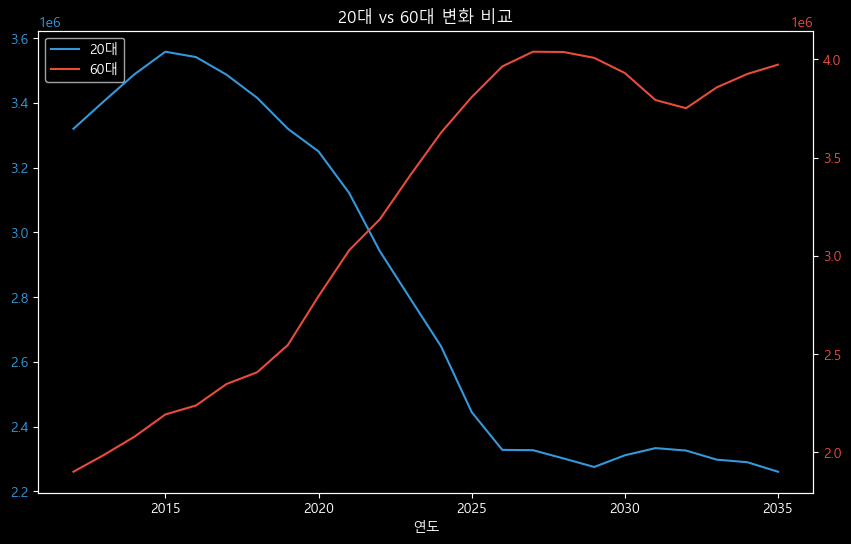

In [57]:
# 그래프
dynamic_per_data_n_index = dynamic_per_data.reset_index()
fig, ax1 = plt.subplots(figsize=(10, 6))

color_1 = '#3498db' # 파란색
ax1.set_xlabel('연도')
ax1.set_ylabel('20대 인구수', color=color_1, fontsize=12, fontweight='bold')
line1 = ax1.plot(dynamic_per_data_n_index['Year'], dynamic_per_data_n_index['20~24'], color=color_1, label='20대')
ax1.tick_params(axis='y', labelcolor=color_1)

ax1.set_ylabel('')

ax2 = ax1.twinx()

color_2 = '#e74c3c' # 빨간색
ax2.set_ylabel('60대 인구수', color=color_2, fontsize=12, fontweight='bold')
line2 = ax2.plot(dynamic_per_data_n_index['Year'], dynamic_per_data_n_index['65~69'], color=color_2, label='60대')
ax2.tick_params(axis='y', labelcolor=color_2)

ax2.set_ylabel('')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('20대 vs 60대 변화 비교')
plt.grid(axis='x', linestyle='--', alpha=0.5) # X축 기준 그리드만 표시
plt.show()

In [58]:
# 연금 고갈 예측
# 2024년 기준
npp = '13'
now_np = 1427700000000000
np_res_2024 = 43704824715000
np_sub_2024 = 50000000000000

# 국민연금 수령자 1인당 금액
res_data_2024 = res_data.groupby('Year').sum().loc[2024]
res_np = np_res_2024 / (res_data_2024['Old_Pension'] + res_data_2024['Disability_Lsp'] + res_data_2024['Disability_Pension'] + res_data_2024['Survivor_Pension'] + res_data_2024['Return_Lsp'] + res_data_2024['Death_Lsp'])

# 국민연금 가입자 1인당 금액
sub_np = np_sub_2024 /  pns_data.groupby('Year').sum().loc[2024]['Subscriber_Count']

# 연령대별 국민연금 가입비율
mask = per_data['Age_Grp'] == '15~19'

per_1819 = per_data.loc[mask].copy()
per_1819['Age_Grp'] = '18~19'

target_ages = ['60~64', '65~69', '70~74', '75~79', '80+']
df_60plus = per_data[per_data['Age_Grp'].isin(target_ages)]
sum_60plus = (df_60plus.groupby('Year', as_index=False).agg({'Population': 'sum'}))
sum_60plus['Age_Grp'] = '60+'

per_data_of_age = pd.concat([per_data, sum_60plus], ignore_index=True)
per_data_of_age = pd.concat([per_data_of_age, per_1819], ignore_index=True)

np_of_age = pns_data.merge(per_data_of_age, left_on=['Year', 'Age_Group'], right_on=['Year', 'Age_Grp'], how='left')
np_of_age = np_of_age[np_of_age['Year']== 2024]
np_of_age['NP_Rate'] = np_of_age['Subscriber_Count'] / np_of_age['Population']

# 미래 가입 인구 구하기
dynamic_per_of_age = dynamic_per_data
dynamic_per_of_age['18~19'] = dynamic_per_data['15~19']
dynamic_per_of_age['60+'] = dynamic_per_data['60~64'] + dynamic_per_data['65~69'] + dynamic_per_data['70~74'] + dynamic_per_data['75~79'] + dynamic_per_data['80+']

np_subs = ['18~19', '20~24', '25~29', '30~34', '35~39', '40~44', '45~49', '50~54', '55~59', '60+']
rows = []

for y in list(range(2025, 2035)):
    row = {'Year': y}
    sum = 0
    for s in np_subs:
        sum += int(dynamic_per_of_age.loc[y].loc[s] * np_of_age[np_of_age['Age_Grp']==s]['NP_Rate'].item())
    row['Sub'] = sum
    rows.append(row)

fut_sub = pd.DataFrame(rows)

# 수령 인구 비율
res_data_Nindex = res_data.reset_index()
res_data_Nindex = res_data_Nindex[res_data_Nindex['Year'] == 2024]
res_data_Nindex['total'] = res_data_Nindex['Old_Pension'] + res_data_Nindex['Disability_Lsp'] + res_data_Nindex['Disability_Pension'] + res_data_Nindex['Survivor_Pension'] + res_data_Nindex['Return_Lsp'] + res_data_Nindex['Death_Lsp']

res_data_Nindex = res_data_Nindex.merge(per_data, left_on=['Year', 'Age_Group'], right_on=['Year', 'Age_Grp'], how='left')
res_data_Nindex['rec_per'] = res_data_Nindex['total'] / res_data_Nindex['Population']

# 미래 수령 인구 구하기
rows = []
for y in list(range(2025, 2036)):
    row = {'Year': y}
    sum = 0

    dynamic_per_data_year = dynamic_per_data.loc[y]
    for i in age_order :
        sum += int(dynamic_per_data_year[i] * res_data_Nindex[res_data_Nindex['Age_Group'] == i]['rec_per'].item())

    row['Recipients'] = sum
    rows.append(row)

fut_rep = pd.DataFrame(rows)

# 고갈 년도 예측하기
fut_np_data = fut_sub.merge(fut_rep, on='Year', how='left')
fut_np_data['in'] = fut_np_data['Sub'] * int(sub_np)
fut_np_data['out'] = fut_np_data['Recipients'] * int(res_np)
fut_np_data['rem'] = 0
for i, row in fut_np_data.iterrows():
    if row['Year'] == 2025:
        fut_np_data.at[i, 'rem'] = now_np + row['in'] - row['out']
    else:
        fut_np_data.at[i, 'rem'] = fut_np_data.at[i-1, 'rem'] + row['in'] - row['out']

fut_np_data

,Year,Sub,Recipients,in,out,rem
0,2025,19002224,7703557,49520232795152,45470422374311,1431749810420841
1,2026,18686597,7896996,48697701573731,46612200520908,1433835311473664
2,2027,18415337,8100831,47990791774751,47815341296613,1434010761951802
3,2028,18120272,8330193,47221845598256,49169155776939,1432063451773119
4,2029,17817079,8561701,46431717666817,50535637071623,1427959532368313
5,2030,17513590,8789259,45640818352570,51878803400457,1421721547320426
6,2031,17083650,8927317,44520384823950,52693693920791,1413548238223585
7,2032,16769622,9062765,43702020633306,53493178856095,1403757080000796
8,2033,16459783,9259037,42894573073009,54651678850351,1391999974223454
9,2034,16164127,9420283,42124086736921,55603437074009,1378520623886366


예상 고갈 시기: 2064.63년


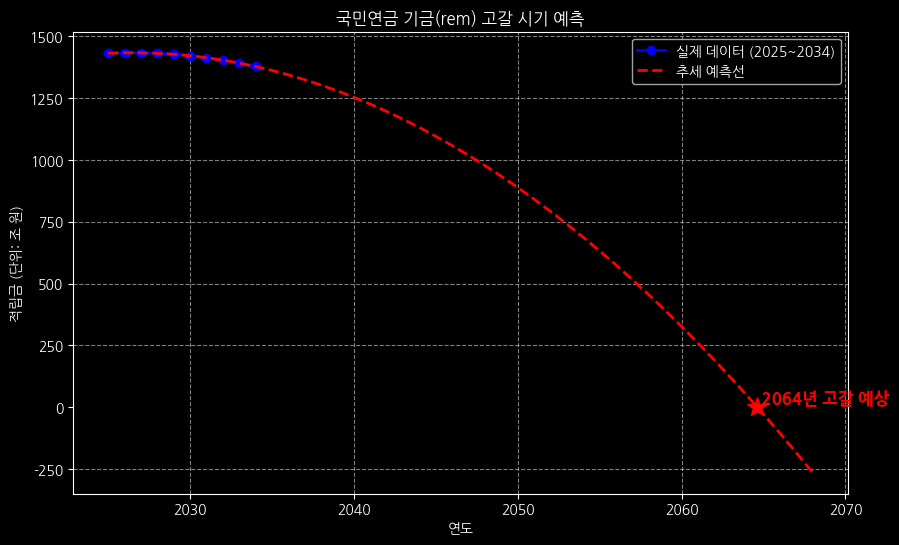

In [59]:
# fut_np_data = fut_np_data.reset_index()
# 2. 데이터 전처리
# 계산의 안정성을 위해 '조' 단위(1e12)로 스케일링
X = fut_np_data['Year'].values
y = fut_np_data['rem'].values / 1e12

# 3. 예측 모델링 (2차 함수 회귀분석)
# y = ax^2 + bx + c 형태의 곡선을 찾습니다.
coeffs = np.polyfit(X, y, 2)
poly_eqn = np.poly1d(coeffs)

roots = poly_eqn.roots
target_year = [r for r in roots if r > 2025][0] # 미래의 시점 선택
print(f"예상 고갈 시기: {target_year:.2f}년")

future_years = np.arange(2025, int(target_year) + 5)
future_values = poly_eqn(future_years)

plt.rcParams['font.family'] = 'NanumGothic' # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

plt.figure(figsize=(10, 6))

plt.plot(X, y, marker='o', label='실제 데이터 (2025~2034)', color='blue', linewidth=2)

plt.plot(future_years, future_values, linestyle='--', label='추세 예측선', color='red', linewidth=2)

plt.axhline(0, color='black', linewidth=1) # 0원 기준선
plt.plot(target_year, 0, marker='*', markersize=15, color='red')
plt.text(target_year, 0, f' {int(target_year)}년 고갈 예상',
         color='red', fontsize=12, fontweight='bold', va='bottom')

plt.title('국민연금 기금(rem) 고갈 시기 예측')
plt.xlabel('연도')
plt.ylabel('적립금 (단위: 조 원)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [60]:
# 간단한 연금 자동조정 장치
# 인구구조, 보험료율, 연금 지급액에 따른 자동 조정 알고리즘
# 추후에 개발